In [1]:
# Imports
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import xtrack as xt
import pickle

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 10
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [25]:
num_part = 5000

# Make a transfer line
# ====================
k_qf_1 = 0.32730047
k_qd_2 = -0.36102915
k_qf_3 = 0.32789126
k_qd_4 = -0.1991137
l_quad = 2

elements = [
            xt.Quadrupole(k1=k_qf_1, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_2, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qf_3, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_4, length=l_quad),
            xt.Drift(length=89.),
            xt.Marker(),
            xt.Multipole(length=1.0, knl=[0.0])
           ]
element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                 "drift_4", "END", "fake_multipole"]
particle_ref = xp.Particles(energy0=24.e9)
line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

# Add air regions
# ===============
Carbon_modified = xc.Material(
        name = 'Carbon modified to be air-like', # Using Luigi's values
        Z = 7.262,
        A = 14.55,
        density = 0.00120479,
        excitation_energy = 85.7e-9,
        radiation_length = 303.9,
        nuclear_radius = 0.25,
        nuclear_elastic_slope = 0.0, #Not relevant for me (Crystal)
        cross_section = [0.270+0.078, 0.270, 0, 0, 0, 0.0]
)
line.insert_element(element=xc.EverestBlock(length=20, material=Carbon_modified), name="Air 1", at_s=40) #xc.materials.Carbon

# Add monitors
# ============
mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=15)
line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=20)
line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=65)
line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=70)

# Generate an initial distribution of particles
# =============================================
line.build_tracker()
line["Air 1"]._tracking = False
# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
dx0 = 0.13
dy0 = 0.0
dpx0 = 0.02
dpy0 = 0.0
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)

nemitt_x = 7.639770207283603e-06
nemitt_y = 3.534081877201574e-06
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line["Air 1"]._tracking = True
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


## Machine parameters

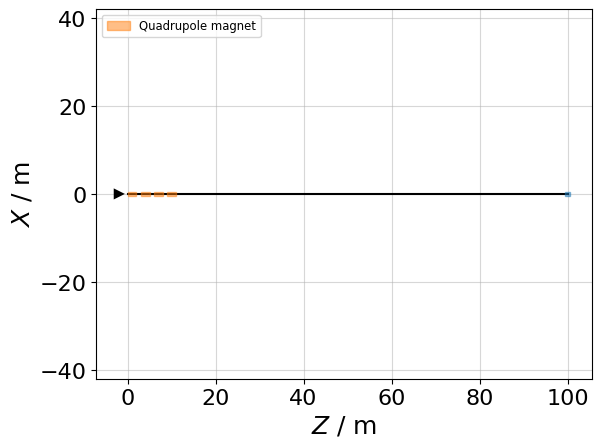

In [26]:
# Compute survey
sv = line.survey()
# Plot ring geometry using Xplt (credits P. Niedermayer)
import xplt
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

In [27]:
# To extract a table with all elements in the lattice
tt = line.get_table()
# Inspect first ten elements
tt.rows[::].show()

name                  s element_type     isthick compound_name
QF1                   0 Quadrupole          True              
drift_1               2 Drift               True              
QD2                   3 Quadrupole          True              
drift_2               5 Drift               True              
QF3                   6 Quadrupole          True              
drift_3               8 Drift               True              
QD4                   9 Quadrupole          True              
drift_4_u_u          11 Drift               True              
monitor air 1 start  15 ParticlesMonitor   False              
drift_4_u_d_u        15 Drift               True              
monitor air 1 end    20 ParticlesMonitor   False              
drift_4_u_d_d        20 Drift               True              
Air 1                40 EverestBlock        True              
drift_4_d_u          60 Drift               True              
monitor air 2 start  65 ParticlesMonitor   False       

In [28]:
# Inspect all quadrupoles
ttquad = tt.rows[tt.element_type=='Quadrupole']
ttquad.show()

name                s element_type     isthick compound_name
QF1                 0 Quadrupole          True              
QD2                 3 Quadrupole          True              
QF3                 6 Quadrupole          True              
QD4                 9 Quadrupole          True              


## Matching

In [29]:
# Reload the initial particles and track them
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

In [30]:
with open('../data/FLUKA_data/airscattering.pickle', 'rb') as f:
    df_fluka_options = pickle.load(f)

# First test with the base material

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.2, 1.5, 'Material: Carbon modified to be air-like\nZ: 7.262, A: 14.55, Density: 0.00120479 g/cm³\nExc. Energy: 8.57e-08 MeV, Rad. Length: 303.9 cm\nNuclear Radius: 0.25 fm, Elastic Slope: 0.0 GeV⁻²\nHcut: 0.02, Only MCS: 0\nCross Section: 3.48e-01, 2.70e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00')

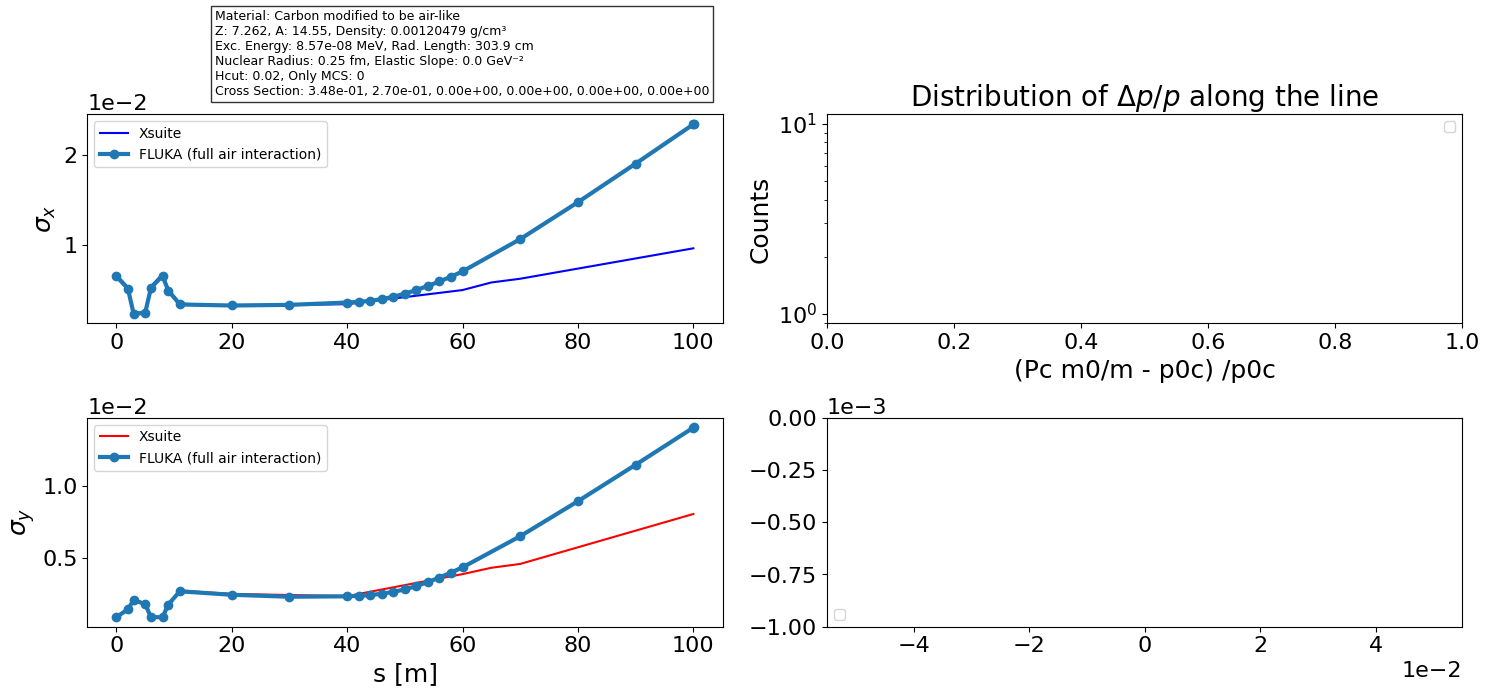

In [31]:
fig,ax = plt.subplots(2,2, figsize=(15,7), tight_layout=True)

s_list = []
sigH_list = []
sigV_list = []

for i in range(len(tw.s)):
    s_list.append(tw.s[i])

    data_H = line.record_last_track.x[:,i]
    filtered_data_H = data_H[(data_H > -0.1) & (data_H < 0.1)]
    sigma_H = np.std(filtered_data_H)

    data_V = line.record_last_track.y[:,i]
    filtered_data_V = data_V[(data_V > -0.1) & (data_V < 0.1)]
    sigma_V = np.std(filtered_data_V)

    sigH_list.append(sigma_H)
    sigV_list.append(sigma_V)

ax[0,0].plot(s_list, sigH_list, c="b", label=f"Xsuite")
ax[1,0].plot(s_list, sigV_list, c="r", label=f"Xsuite")


#FLUKA options
ax[0,0].plot(df_fluka_options.Dist, df_fluka_options.X_air/100, lw=3, marker="o", label="FLUKA (full air interaction)")
ax[1,0].plot(df_fluka_options.Dist, df_fluka_options.Y_air/100, lw=3, marker='o', label="FLUKA (full air interaction)")


ax[0,0].set_ylabel(r"$\sigma_x$")
ax[1,0].set_ylabel(r"$\sigma_y$")
ax[1,0].set_xlabel("s [m]")
ax[0,0].legend()
ax[1,0].legend()

ax[0,1].set_yscale("log")
ax[0,1].set_title("Distribution of $\Delta p/p$ along the line")
ax[0,1].set_xlabel("(Pc m0/m - p0c) /p0c")
ax[0,1].set_ylabel("Counts")
ax[0,1].legend()

ax[1,1].autoscale()
ax[1,1].set_ylim(-0.001, 0.0)
ax[1,1].legend(loc="lower left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    ))

material = line['Air 1']._material

material_details = f"""Material: {material.name}
Z: {material.Z}, A: {material.A}, Density: {material.density} g/cm³
Exc. Energy: {material.excitation_energy} MeV, Rad. Length: {material.radiation_length} cm
Nuclear Radius: {material.nuclear_radius} fm, Elastic Slope: {material.nuclear_elastic_slope} GeV⁻²
Hcut: {material.hcut}, Only MCS: {material._only_mcs}
Cross Section: {', '.join(f'{cs:.2e}' for cs in material.cross_section)}"""

props = dict(boxstyle='square', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax[0,0].text(0.2, 1.5, material_details, transform=ax[0,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Second test

Text(0.2, 1.5, 'Material: Carbon modified to be air-like\nZ: 7.262, A: 14.55, Density: 0.0049 g/cm³\nExc. Energy: 8.57e-08 MeV, Rad. Length: 303.9 cm\nNuclear Radius: 0.25 fm, Elastic Slope: 0.0 GeV⁻²\nHcut: 0.02, Only MCS: 0\nCross Section: 3.48e-01, 2.70e-01, 0.00e+00, 0.00e+00, 0.00e+00, 7.60e-05')

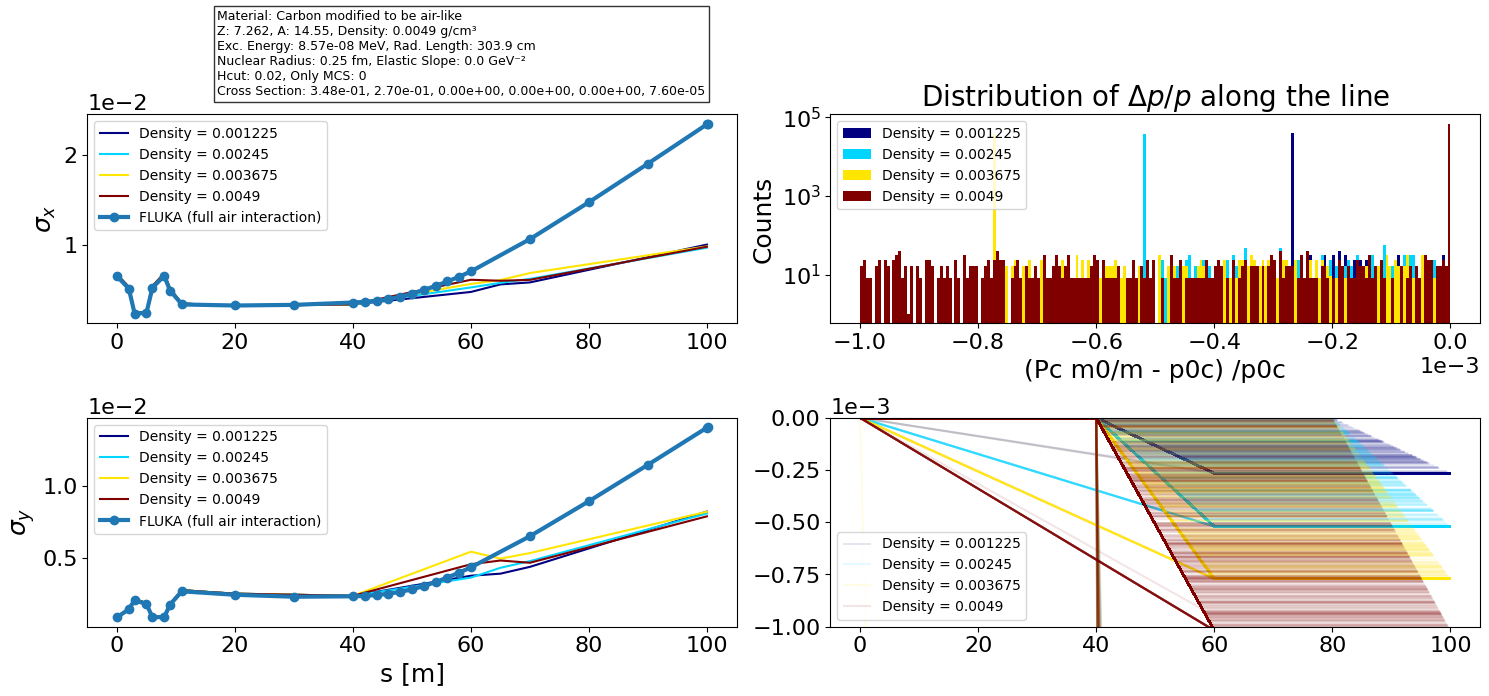

In [10]:
fig,ax = plt.subplots(2,2, figsize=(15,7), tight_layout=True)

densities = [0.001225, 0.001225*2, 0.001225*3, 0.001225*4]
colors = cm.jet(np.linspace(0, 1, len(densities)))  # Using a colormap

for idx, density in enumerate(densities):

    line['Air 1']._material.density = density 

    # Loop through the tracking
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

    s_list = []
    sigH_list = []
    sigV_list = []

    for i in range(len(tw.s)):
        s_list.append(tw.s[i])
        data_H = line.record_last_track.x[:,i]
        filtered_data_H = data_H[(data_H > -0.1) & (data_H < 0.1)]
        sigma_H = np.std(filtered_data_H)

        data_V = line.record_last_track.y[:,i]
        filtered_data_V = data_V[(data_V > -0.1) & (data_V < 0.1)]
        sigma_V = np.std(filtered_data_V)

        sigH_list.append(sigma_H)
        sigV_list.append(sigma_V)
    ax[0,0].plot(s_list, sigH_list, c=colors[idx], label=f"Density = {density}")
    ax[1,0].plot(s_list, sigV_list, c=colors[idx], label=f"Density = {density}")

    # Momentum spread
    ax[0,1].hist(line.record_last_track.delta.reshape(np.shape(line.record_last_track.delta)[0]*np.shape(line.record_last_track.delta)[1],), bins = 200, range=(-0.001, 0), color=colors[idx], label=f"Density = {density}");

    lines = [list(zip(line.record_last_track.s[i], line.record_last_track.delta[i])) for i in range(len(line.record_last_track.s))]
    line_collection = LineCollection(lines, alpha=0.1, colors=[colors[idx]], label=f"Density = {density}")
    ax[1,1].add_collection(line_collection)

#FLUKA options
ax[0,0].plot(df_fluka_options.Dist, df_fluka_options.X_air/100, lw=3, marker="o", label="FLUKA (full air interaction)")
ax[1,0].plot(df_fluka_options.Dist, df_fluka_options.Y_air/100, lw=3, marker='o', label="FLUKA (full air interaction)")


ax[0,0].set_ylabel(r"$\sigma_x$")
ax[1,0].set_ylabel(r"$\sigma_y$")
ax[1,0].set_xlabel("s [m]")
ax[0,0].legend()
ax[1,0].legend()

ax[0,1].set_yscale("log")
ax[0,1].set_title("Distribution of $\Delta p/p$ along the line")
ax[0,1].set_xlabel("(Pc m0/m - p0c) /p0c")
ax[0,1].set_ylabel("Counts")
ax[0,1].legend()

ax[1,1].autoscale()
ax[1,1].set_ylim(-0.001, 0.0)
ax[1,1].legend(loc="lower left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    ))

material = line['Air 1']._material

material_details = f"""Material: {material.name}
Z: {material.Z}, A: {material.A}, Density: {material.density} g/cm³
Exc. Energy: {material.excitation_energy} MeV, Rad. Length: {material.radiation_length} cm
Nuclear Radius: {material.nuclear_radius} fm, Elastic Slope: {material.nuclear_elastic_slope} GeV⁻²
Hcut: {material.hcut}, Only MCS: {material._only_mcs}
Cross Section: {', '.join(f'{cs:.2e}' for cs in material.cross_section)}"""

props = dict(boxstyle='square', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax[0,0].text(0.2, 1.5, material_details, transform=ax[0,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Compare with FLUKA

In [11]:
with open('xsuite_beam_size_full_int.p', 'rb') as f:
    df_xsuite_full_int = pickle.load(f)

with open('../data/FLUKA_data/airscattering.pickle', 'rb') as f:
    df_fluka_options = pickle.load(f)


fig, ax = plt.subplots(3,1, figsize=(10,8), tight_layout=True, height_ratios=[1, 3, 3])

ax[1].plot(df_xsuite_full_int.s, df_xsuite_full_int.sigH*1000, marker="o", label="Xsuite (xcoll full int)")
ax[2].plot(df_xsuite_full_int.s, df_xsuite_full_int.sigV*1000, marker="o", label="Xsuite (xcoll full int)")


#FLUKA options
ax[1].plot(df_fluka_options.Dist, df_fluka_options.X_air*10, label="FLUKA (full air interaction)")
ax[2].plot(df_fluka_options.Dist, df_fluka_options.Y_air*10, label="FLUKA (full air interaction)")


ax[1].set_xlabel("s [m]")
ax[1].set_ylabel(r"$\sigma_{H}$ [mm]")
ax[1].legend(loc="upper left")
# ax[0].set_ylim(0, 3)

ax[2].set_xlabel("s [m]")
ax[2].set_ylabel(r"$\sigma_{V}$ [mm]")
ax[2].legend()
# ax[1].set_ylim(0, 3)

fig.suptitle("Comparison between air interaction models\nAir region between 40 and 60 m")

plt.savefig("compare_simulation.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

## Different variables

In [12]:
material

Material(Z=7.262, A=14.55, density=0.0049, excitation_energy=8.57e-08, nuclear_radius=0.25, nuclear_elastic_slope=0.0, cross_section=[3.48e-01 2.70e-01 0.00e+00 0.00e+00 0.00e+00 7.60e-05], hcut=0.02, name=Carbon modified to be air-like, _only_mcs=0, radiation_length=303.9)

In [13]:
line['Air 1']._material.density = 0.001225

In [14]:
line['Air 1']._material.Z

7.262

Text(0.2, 1.5, 'Material: Carbon modified to be air-like\nZ: 8.0, A: 14.55, Density: 0.001225 g/cm³\nExc. Energy: 8.57e-08 MeV, Rad. Length: 303.9 cm\nNuclear Radius: 0.25 fm, Elastic Slope: 0.0 GeV⁻²\nHcut: 0.02, Only MCS: 0\nCross Section: 3.48e-01, 2.70e-01, 0.00e+00, 0.00e+00, 0.00e+00, 7.60e-05')

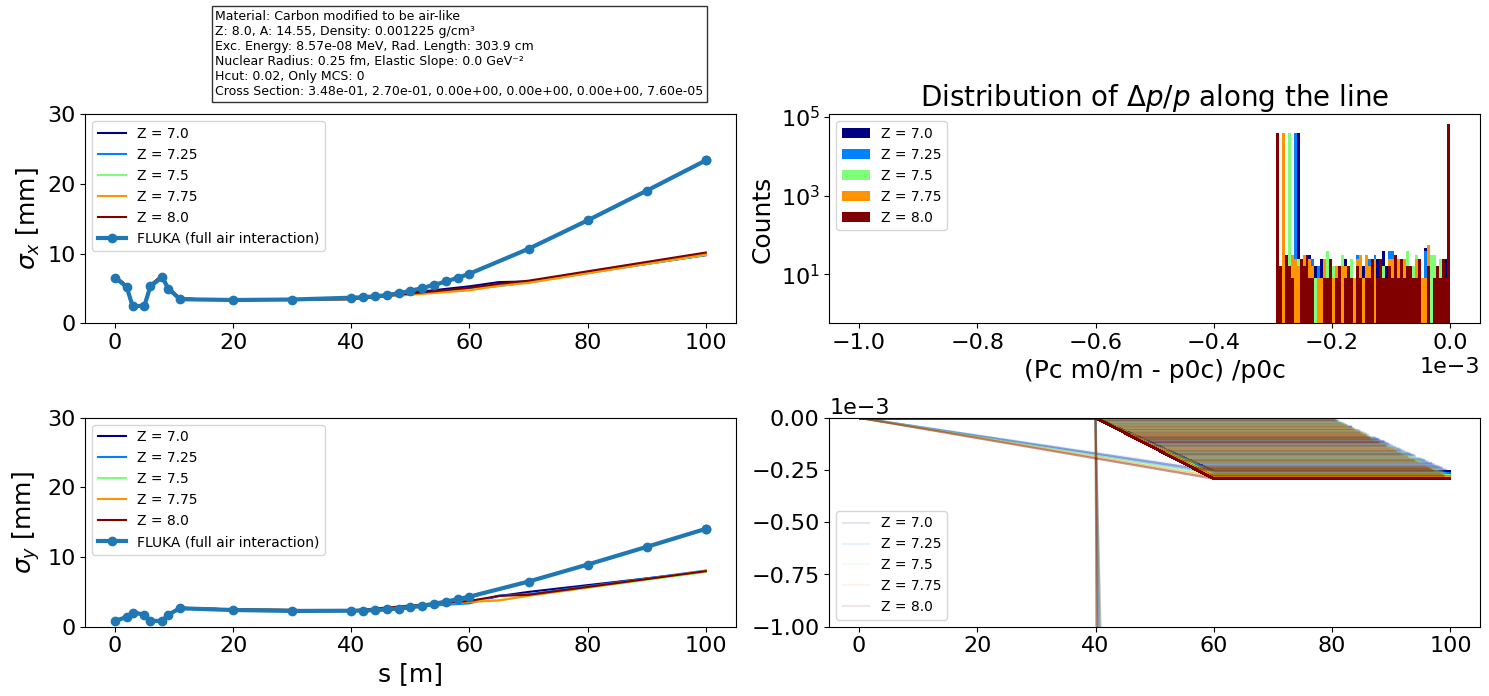

In [15]:
fig,ax = plt.subplots(2,2, figsize=(15,7), tight_layout=True)

variables = np.linspace(7,8, 5)
variable_str = "Z"
colors = cm.jet(np.linspace(0, 1, len(variables)))  # Using a colormap

for idx, variable in enumerate(variables):

    line['Air 1']._material.Z = variable 

    # Loop through the tracking
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

    s_list = []
    sigH_list = []
    sigV_list = []

    for i in range(len(tw.s)):
        s_list.append(tw.s[i])
        data_H = line.record_last_track.x[:,i]
        filtered_data_H = data_H[(data_H > -0.1) & (data_H < 0.1)]
        sigma_H = np.std(filtered_data_H)

        data_V = line.record_last_track.y[:,i]
        filtered_data_V = data_V[(data_V > -0.1) & (data_V < 0.1)]
        sigma_V = np.std(filtered_data_V)

        sigH_list.append(sigma_H)
        sigV_list.append(sigma_V)
    ax[0,0].plot(s_list, np.array(sigH_list)*1000, c=colors[idx], label=f"{variable_str} = {variable}")
    ax[1,0].plot(s_list, np.array(sigV_list)*1000, c=colors[idx], label=f"{variable_str} = {variable}")

    # Momentum spread
    ax[0,1].hist(line.record_last_track.delta.reshape(np.shape(line.record_last_track.delta)[0]*np.shape(line.record_last_track.delta)[1],), bins = 200, range=(-0.001, 0), color=colors[idx], label=f"{variable_str} = {variable}");

    lines = [list(zip(line.record_last_track.s[i], line.record_last_track.delta[i])) for i in range(len(line.record_last_track.s))]
    line_collection = LineCollection(lines, alpha=0.1, colors=[colors[idx]], label=f"{variable_str} = {variable}")
    ax[1,1].add_collection(line_collection)

#FLUKA options
ax[0,0].plot(df_fluka_options.Dist, df_fluka_options.X_air*10, lw=3, marker="o", label="FLUKA (full air interaction)")
ax[1,0].plot(df_fluka_options.Dist, df_fluka_options.Y_air*10, lw=3, marker='o', label="FLUKA (full air interaction)")


ax[0,0].set_ylabel(r"$\sigma_x$ [mm]")
ax[1,0].set_ylabel(r"$\sigma_y$ [mm]")
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 30)
ax[1,0].set_xlabel("s [m]")
ax[0,0].legend()
ax[1,0].legend()

ax[0,1].set_yscale("log")
ax[0,1].set_title("Distribution of $\Delta p/p$ along the line")
ax[0,1].set_xlabel("(Pc m0/m - p0c) /p0c")
ax[0,1].set_ylabel("Counts")
ax[0,1].legend()

ax[1,1].autoscale()
ax[1,1].set_ylim(-0.001, 0.0)
ax[1,1].legend(loc="lower left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    ))

material = line['Air 1']._material

material_details = f"""Material: {material.name}
Z: {material.Z}, A: {material.A}, Density: {material.density} g/cm³
Exc. Energy: {material.excitation_energy} MeV, Rad. Length: {material.radiation_length} cm
Nuclear Radius: {material.nuclear_radius} fm, Elastic Slope: {material.nuclear_elastic_slope} GeV⁻²
Hcut: {material.hcut}, Only MCS: {material._only_mcs}
Cross Section: {', '.join(f'{cs:.2e}' for cs in material.cross_section)}"""

props = dict(boxstyle='square', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax[0,0].text(0.2, 1.5, material_details, transform=ax[0,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# Just checking how repeatable the results are

(-0.1, 0.1)

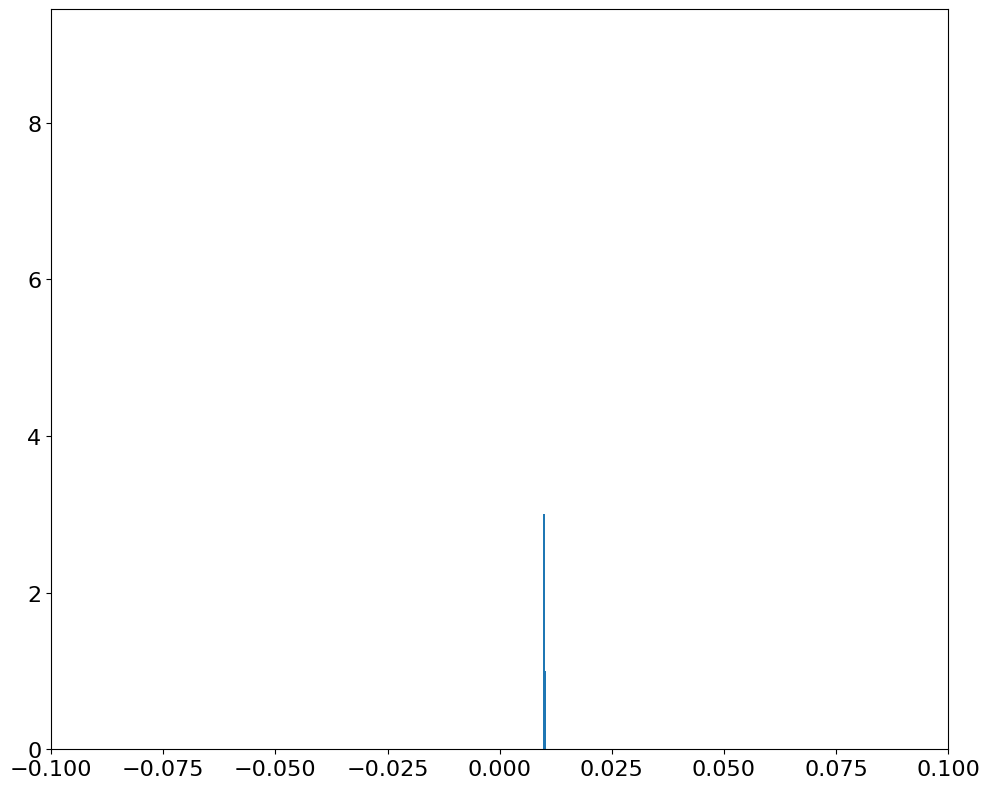

In [16]:
sigma_list = []
for i in range(50):

    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

    data_H = line.record_last_track.x[:,-2]
    filtered_data_H = data_H[(data_H > -0.1) & (data_H < 0.1)]
    sigma_H = np.std(filtered_data_H)

    sigma_list.append(sigma_H)

fig, ax = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
ax.hist(sigma_list, bins=20);
ax.set_xlim(-0.1, 0.1)

(-0.1, 0.1)

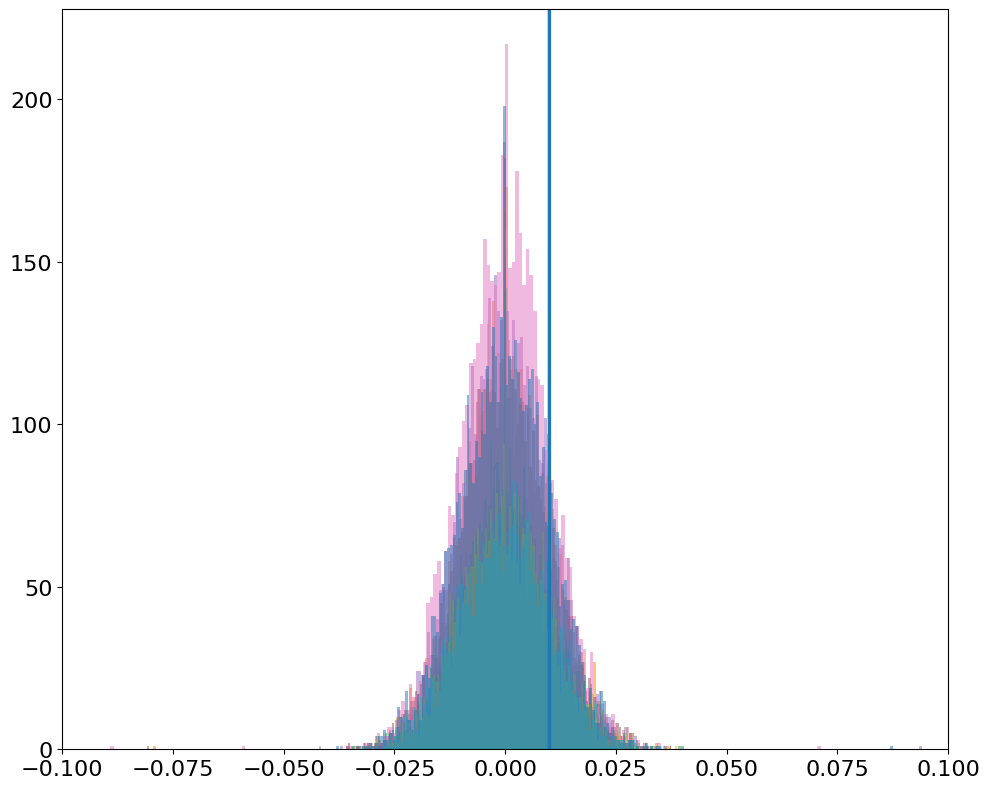

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
ax.hist(sigma_list, bins=20);
for i in range(10):

    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

    data = line.record_last_track.x[:,-2]
    filtered_data = data[(data > -0.1) & (data < 0.1)]

    ax.hist(filtered_data, bins=200, alpha=0.5);

    sigma = np.std(filtered_data)
    ax.axvline(sigma)

ax.set_xlim(-0.1, 0.1)